In [1]:
##imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import plotly.express as px
import itertools

from pydataset import data
from scipy import stats
import statistics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report,confusion_matrix,recall_score,precision_score,accuracy_score


from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.ensemble import RandomForestClassifier,IsolationForest
from sklearn.feature_selection import RFE, SelectKBest, f_regression

from sklearn.cluster import DBSCAN

import env

import warnings
warnings.filterwarnings("ignore")


# Use DBSCAN to detect anomalies in other products from the customers dataset. The database name is grocery_db.

In [12]:
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/grocery_db'

df = pd.read_sql('SELECT * FROM grocery_customers', url,index_col="customer_id")
df.head()
df0=df.copy()

Fresh <i  Milk <j  Grocery <k


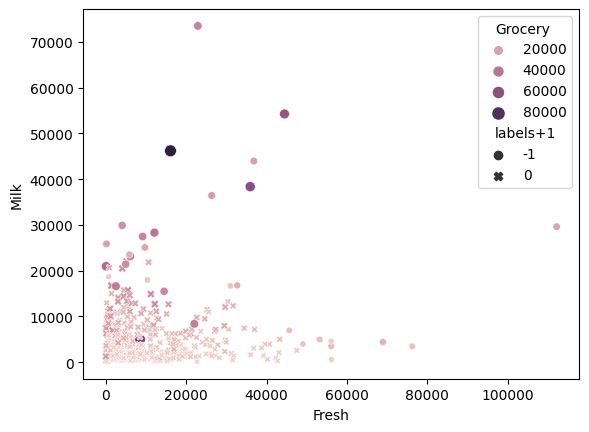

Fresh <i  Milk <j  Frozen <k


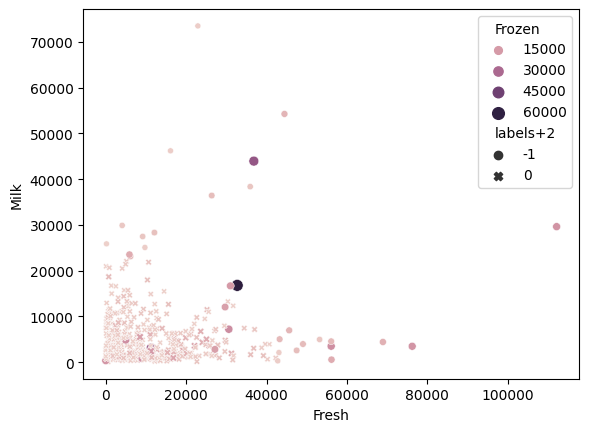

Fresh <i  Milk <j  Detergents_Paper <k


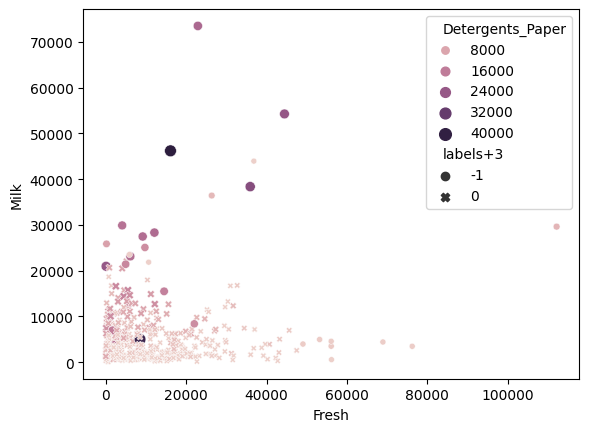

Fresh <i  Milk <j  Delicassen <k


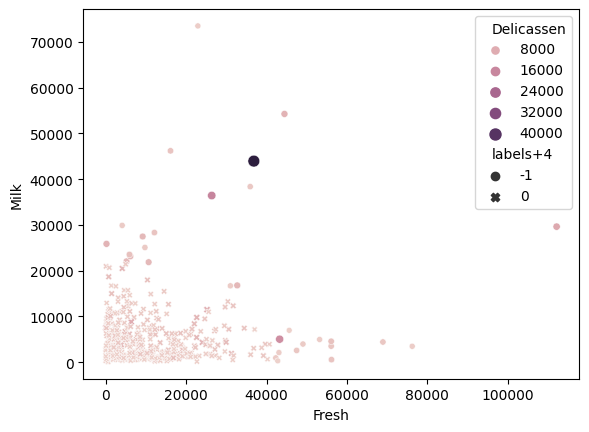

Fresh <i  Grocery <j  Frozen <k


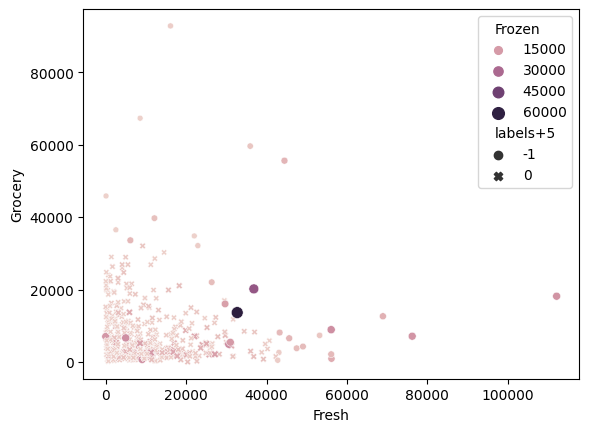

Fresh <i  Grocery <j  Detergents_Paper <k


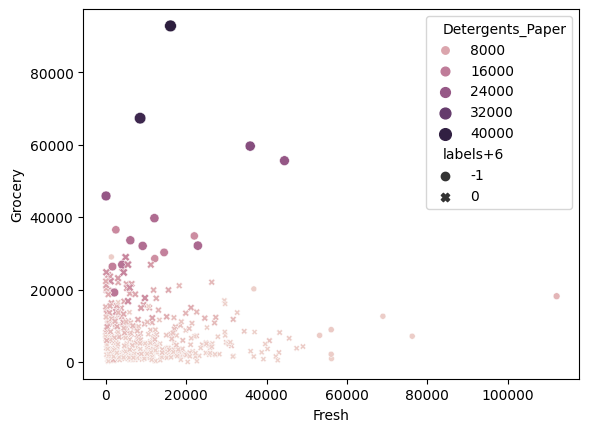

Fresh <i  Grocery <j  Delicassen <k


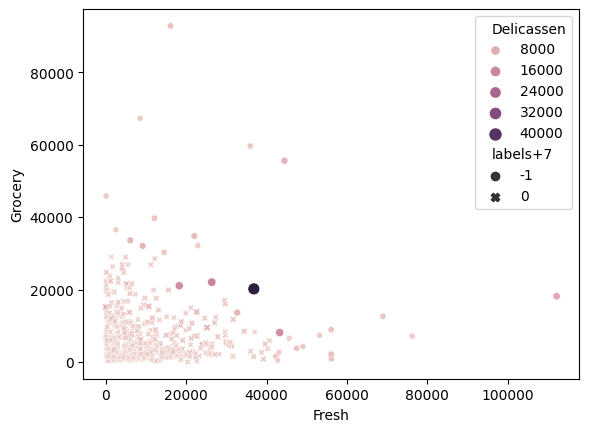

Fresh <i  Frozen <j  Detergents_Paper <k


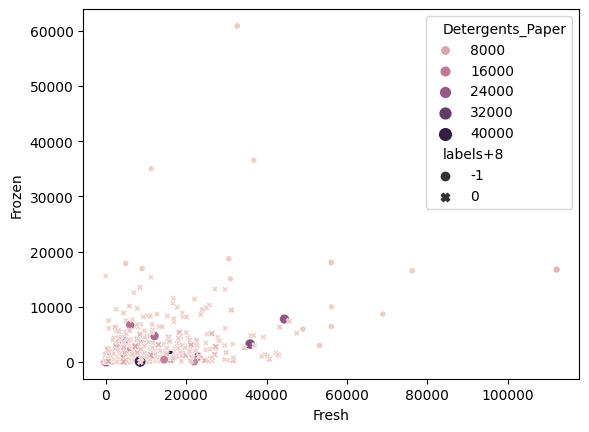

Fresh <i  Frozen <j  Delicassen <k


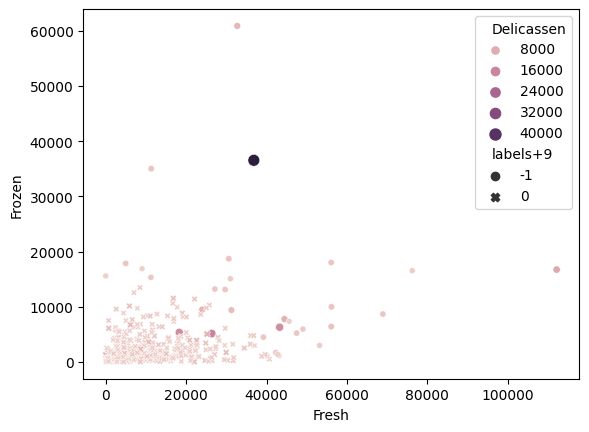

Fresh <i  Detergents_Paper <j  Delicassen <k


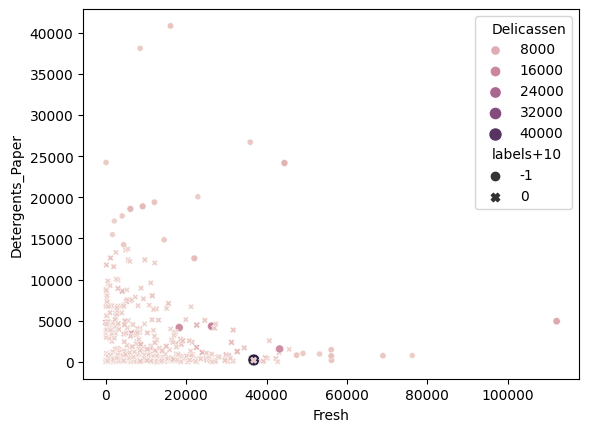

Milk <i  Grocery <j  Frozen <k


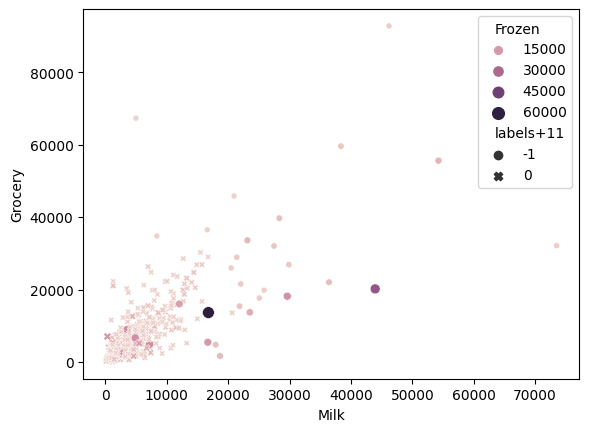

Milk <i  Grocery <j  Detergents_Paper <k


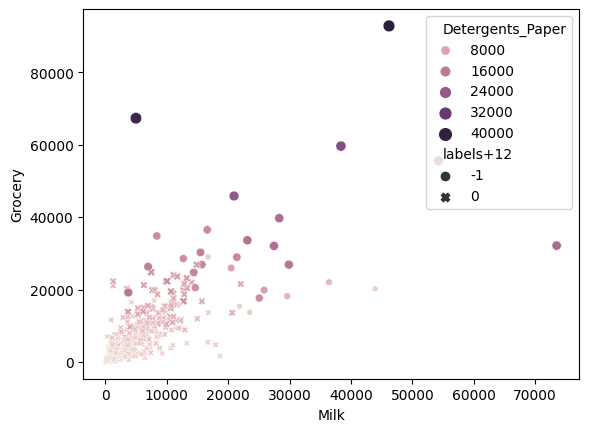

Milk <i  Grocery <j  Delicassen <k


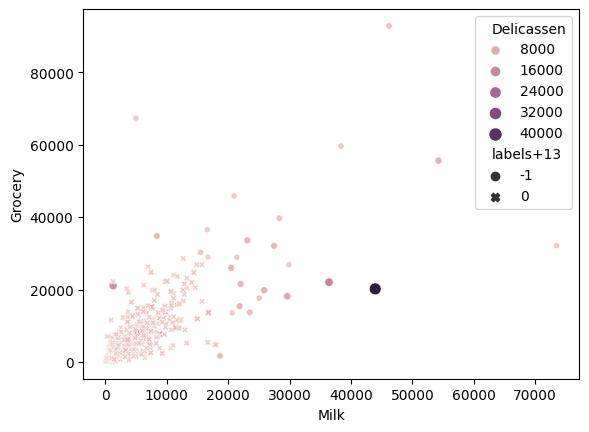

Milk <i  Frozen <j  Detergents_Paper <k


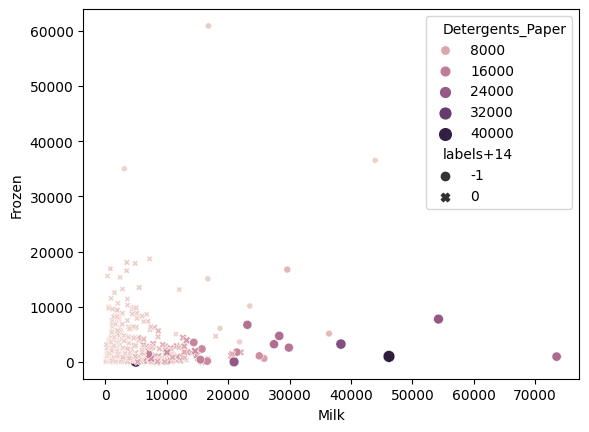

Milk <i  Frozen <j  Delicassen <k


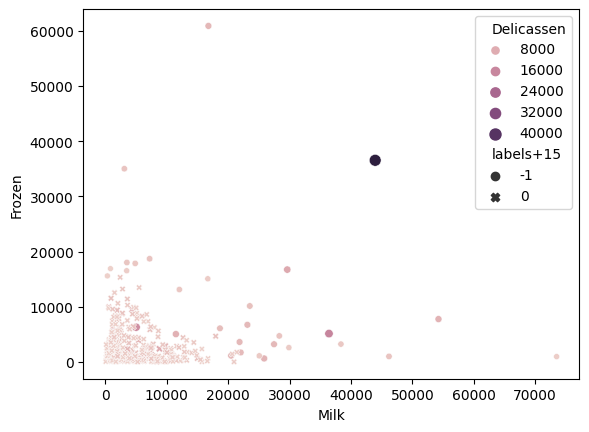

Milk <i  Detergents_Paper <j  Delicassen <k


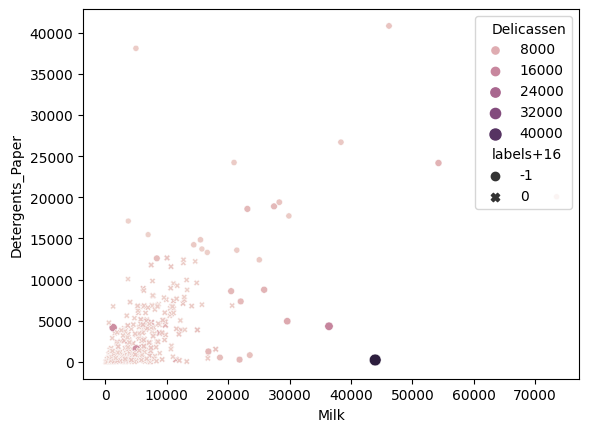

Grocery <i  Frozen <j  Detergents_Paper <k


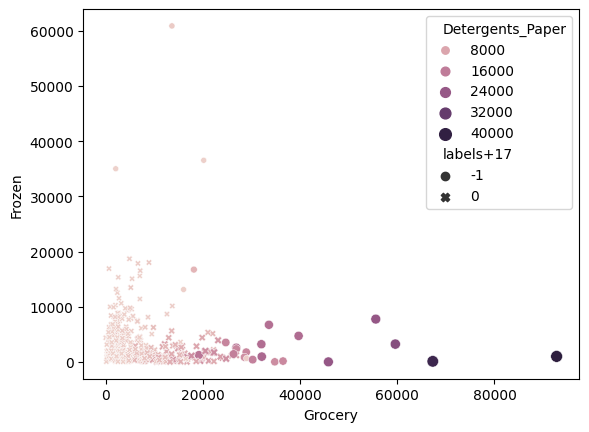

Grocery <i  Frozen <j  Delicassen <k


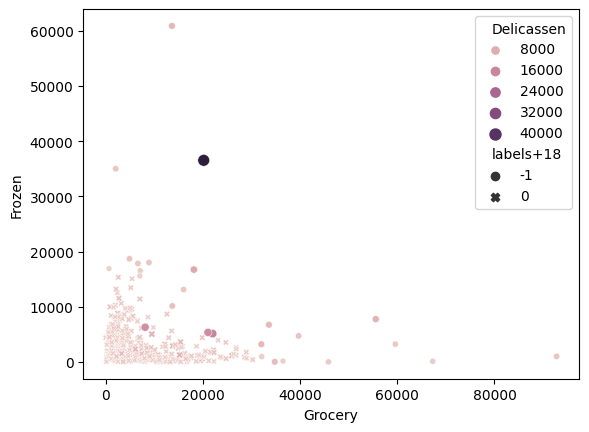

Grocery <i  Detergents_Paper <j  Delicassen <k


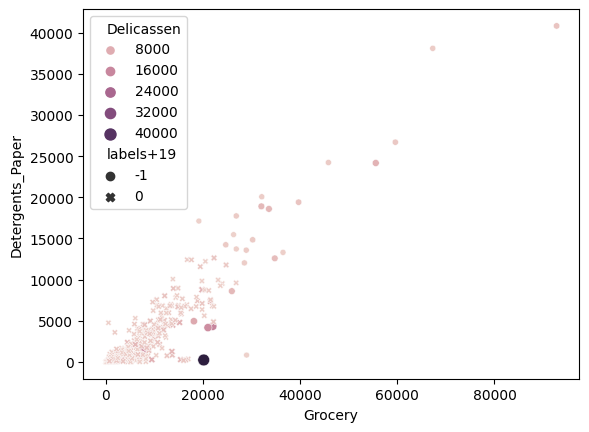

Frozen <i  Detergents_Paper <j  Delicassen <k


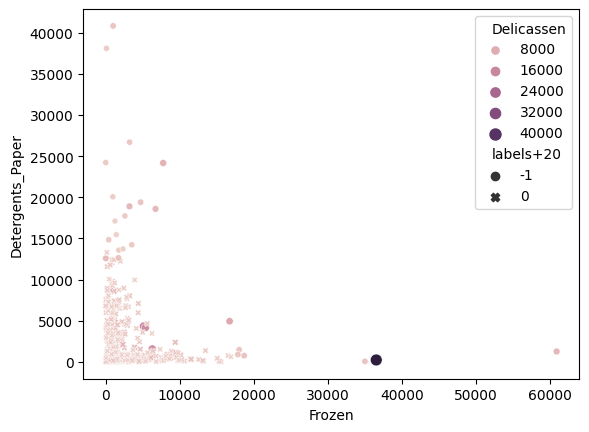

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels+1,labels+2,...,labels+12,labels+13,labels+14,labels+15,labels+16,labels+17,labels+18,labels+19,labels+20,outlier_cat
customer_id,,,,,,,,,,,,,,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338,0,0,...,0,0,0,0,0,0,0,0,0,not_outlier
1,2,3,7057,9810,9568,1762,3293,1776,0,0,...,0,0,0,0,0,0,0,0,0,not_outlier
2,2,3,6353,8808,7684,2405,3516,7844,0,0,...,0,0,0,0,0,0,0,0,0,not_outlier
3,1,3,13265,1196,4221,6404,507,1788,0,0,...,0,0,0,0,0,0,0,0,0,not_outlier
4,2,3,22615,5410,7198,3915,1777,5185,0,0,...,0,0,0,0,0,0,0,0,0,not_outlier
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204,0,-1,...,0,0,0,-1,0,-1,-1,0,0,minor_anom
436,1,3,39228,1431,764,4510,93,2346,0,0,...,0,0,0,0,0,0,0,0,0,major_anom
437,2,3,14531,15488,30243,437,14841,1867,-1,0,...,-1,-1,-1,0,-1,-1,0,-1,-1,minor_anom


In [13]:
# start with fresh dataframe
df = df0.copy()

# making iterable list
products=['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']

x=0
for i,j,k in list(itertools.combinations(products, 3)):
    print(i,"<i ",j,"<j ",k,"<k")
    # Make the scaler
    scaler = MinMaxScaler()

    # Fit the scaler
    scaler.fit(df[[i,j,k]])

    # Use the scaler
    scaled_array = scaler.transform(df[[i,j,k]])

    scaled_df = pd.DataFrame(scaled_array, 
                            columns=["Scaled_" + column for column in [i,j,k]])
    #df = df.merge(scaled_df, on=df.index)
    #df = df.drop(columns=['key_0'])

    # Make the object
    dbsc = DBSCAN(eps = scaled_df.std().mean(), min_samples = int(len(df)*.68*.1))

    # Fit the object
    dbsc.fit(scaled_df)

    #assigning the object
    x += 1
    df[f'labels+{x}'] = dbsc.labels_

    #plot it 2d
    sns.scatterplot(data= df,x=i, y=j, hue=k, size=k, style=f'labels+{x}')
    plt.show()
    #plot it 3d
    #fig = px.scatter_3d(data_frame = df,x = i,y = j,z = k,color = f'labels+{x}',)
    #fig.update_traces(marker_size = 3)
    #fig.show()
df["outlier_cat"] = np.where(df.filter(like="labels").sum(axis=1) == 0,"not_outlier",
                    np.where(df.filter(like="labels").sum(axis=1) < df.filter(like="labels").sum(axis=1).sort_values().unique().min()*1/3,"minor_anom",
                    np.where(df.filter(like="labels").sum(axis=1) < df.filter(like="labels").sum(axis=1).sort_values().unique().min()*2/3,"nom_anom",
                    "major_anom")))
df

In [5]:
df[df.outlier_cat == "major_anom"]

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels+1,labels+2,...,labels+12,labels+13,labels+14,labels+15,labels+16,labels+17,labels+18,labels+19,labels+20,outlier_cat
customer_id,,,,,,,,,,,,,,,,,,,,,
22,1,3,31276,1917,4469,9408,2381,4334,0,0,...,0,0,0,0,0,0,0,0,0,major_anom
28,2,3,4113,20484,25957,1158,8604,5206,0,0,...,-1,-1,0,-1,-1,0,0,-1,0,major_anom
29,1,3,43088,2100,2609,1200,1107,823,0,-1,...,0,0,0,0,0,0,0,0,0,major_anom
40,1,3,24025,4332,4757,9510,1145,5864,0,0,...,0,0,0,0,0,0,0,0,0,major_anom
45,2,3,5181,22044,21531,1740,7353,4985,0,0,...,0,-1,0,-1,-1,0,0,0,0,major_anom
77,2,3,12205,12697,28540,869,12034,1009,0,0,...,-1,0,0,0,0,-1,0,-1,0,major_anom
109,2,3,1406,16729,28986,673,836,3,0,0,...,-1,-1,0,0,0,-1,0,-1,0,major_anom
129,1,3,42312,926,1510,1718,410,1819,0,0,...,0,0,0,0,0,0,0,0,0,major_anom
163,2,3,5531,15726,26870,2367,13726,446,0,0,...,-1,0,-1,0,-1,-1,0,-1,-1,major_anom


# Use DBSCAN to detect anomalies in requests from the curriculum access logs in the curriculum_logs database.

In [16]:
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'

df = pd.read_sql('SELECT * FROM logs', url)
df1=df.copy()
df.head()

,date,time,path,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [87]:
df=df1.copy()
df

,date,time,path,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
...,...,...,...,...,...,...
900218,2021-04-21,16:41:51,jquery/personal-site,64,28.0,71.150.217.33
900219,2021-04-21,16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33
900220,2021-04-21,16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33
900221,2021-04-21,16:44:37,anomaly-detection/discrete-probabilistic-methods,744,28.0,24.160.137.86


,count,nunique
path,,
%20https://github.com/RaulCPena,1,1
',1,1
",%20https://github.com/RaulCPena",1,1
.git,1,1
.gitignore,2,2
...,...,...
web-dev-day-two,2,1
where,1,1
working-with-time-series-data,15,6


In [37]:
df[["user_id","path"]].groupby(["user_id"]).agg(["count","nunique"]).droplevel(axis=1,level=0)


,count,nunique
user_id,,
1,7404,976
2,1541,151
3,1562,169
4,692,143
5,1701,197
...,...,...
977,86,12
978,55,18
979,127,20


count <i  nunique <j


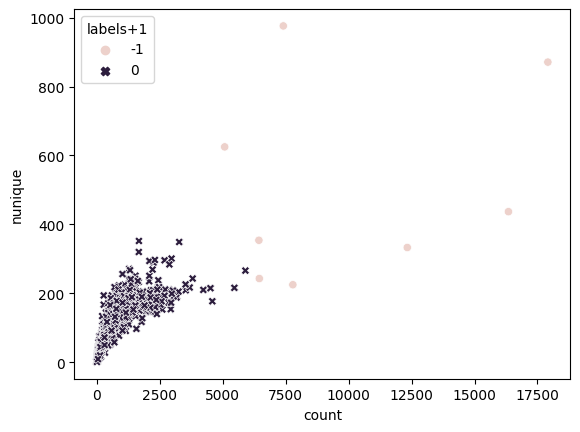

,count,nunique,Scaled_count,Scaled_nunique,labels+1
user_id,,,,,
1,7404,976,0.413298,1.000000,-1
2,1541,151,0.085976,0.153846,0
3,1562,169,0.087148,0.172308,0
4,692,143,0.038577,0.145641,0
5,1701,197,0.094908,0.201026,0
...,...,...,...,...,...
977,86,12,0.004745,0.011282,0
978,55,18,0.003015,0.017436,0
979,127,20,0.007034,0.019487,0


In [86]:
# start with fresh dataframe
df = df1.copy()
df = df[["user_id","path"]].groupby(["user_id"]).agg(["count","nunique"]).droplevel(axis=1,level=0).reset_index()
# making iterable list
products=['count','nunique']

x=0
for i,j in list(itertools.combinations(products, 2)):
    print(i,"<i ",j,"<j")
    # Make the scaler
    scaler = MinMaxScaler()
#
    ## Fit the scaler
    scaler.fit(df[[i,j]])
#
    ## Use the scaler
    scaled_array = scaler.transform(df[[i,j]])
#
    scaled_df = pd.DataFrame(scaled_array, columns=["Scaled_" + column for column in [i,j]])
    df.reset_index(inplace=True)
    df = pd.concat([df,scaled_df],axis=1)
    df.drop
    df = df.drop(columns=['index'])
    df.set_index("user_id",inplace=True)

    # Make the object
    dbsc = DBSCAN(eps = .1, min_samples = 20)

    # Fit the object
    dbsc.fit(scaled_df)

    #assigning the object
    x += 1
    df[f'labels+{x}'] = dbsc.labels_

    #plot it 2d
    sns.scatterplot(data= df,x=i, y=j,hue= f'labels+{x}', style=f'labels+{x}')
    plt.show()
    #plot it 3d
    #fig = px.scatter_3d(data_frame = df,x = i,y = j,z = k,color = f'labels+{x}',)
    #fig.update_traces(marker_size = 3)
    #fig.show()
df

In [85]:
df[df["labels+1"] != 0]

,count,nunique,Scaled_count,Scaled_nunique,labels+1
user_id,,,,,
1,7404,976,0.413298,1.000000,-1
11,17913,871,1.000000,0.892308,-1
53,12329,333,0.688254,0.340513,-1
64,16347,437,0.912573,0.447179,-1
248,5075,625,0.283274,0.640000,-1
314,7783,225,0.434457,0.229744,-1
495,6451,243,0.360094,0.248205,-1
581,6434,354,0.359145,0.362051,-1


count <i  nunique <j


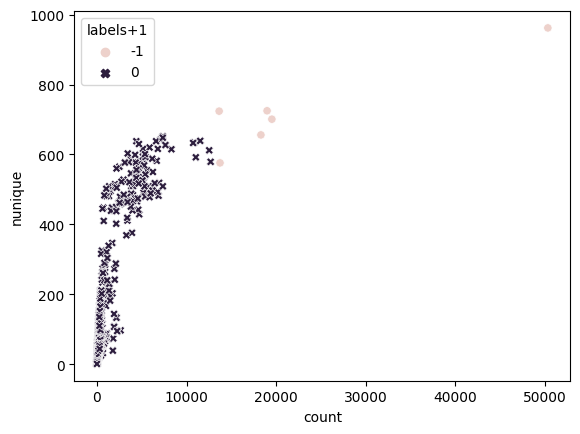

,count,nunique,Scaled_count,Scaled_nunique,labels+1
path,,,,,
%20https://github.com/RaulCPena,1,1,0.000000,0.000000,0
',1,1,0.000000,0.000000,0
",%20https://github.com/RaulCPena",1,1,0.000000,0.000000,0
.git,1,1,0.000000,0.000000,0
.gitignore,2,2,0.000020,0.001041,0
...,...,...,...,...,...
web-dev-day-two,2,1,0.000020,0.000000,0
where,1,1,0.000000,0.000000,0
working-with-time-series-data,15,6,0.000278,0.005203,0


In [105]:
# start with fresh dataframe
df = df1.copy()
df = df[["user_id","path"]].groupby(["path"]).agg(["count","nunique"]).droplevel(axis=1,level=0).reset_index()
# making iterable list
products=['count','nunique']

x=0
for i,j in list(itertools.combinations(products, 2)):
    print(i,"<i ",j,"<j")
    # Make the scaler
    scaler = MinMaxScaler()
#
    ## Fit the scaler
    scaler.fit(df[[i,j]])
#
    ## Use the scaler
    scaled_array = scaler.transform(df[[i,j]])
#
    scaled_df = pd.DataFrame(scaled_array, columns=["Scaled_" + column for column in [i,j]])
    df.reset_index(inplace=True)
    df = pd.concat([df,scaled_df],axis=1)
    df.drop
    df = df.drop(columns=['index'])
    df.set_index("path",inplace=True)

    # Make the object
    dbsc = DBSCAN(eps = .1, min_samples = 20)

    # Fit the object
    dbsc.fit(scaled_df)

    #assigning the object
    x += 1
    df[f'labels+{x}'] = dbsc.labels_

    #plot it 2d
    sns.scatterplot(data= df,x=i, y=j,hue= f'labels+{x}', style=f'labels+{x}')
    plt.show()
    #plot it 3d
    #fig = px.scatter_3d(data_frame = df,x = i,y = j,z = k,color = f'labels+{x}',)
    #fig.update_traces(marker_size = 3)
    #fig.show()
df

In [106]:
df[df["labels+1"] < 0]

,count,nunique,Scaled_count,Scaled_nunique,labels+1
path,,,,,
/,50313,962,1.000000,1.000000,-1
html-css,13635,724,0.270989,0.752341,-1
java-iii,13733,576,0.272937,0.598335,-1
javascript-i,18983,725,0.377286,0.753382,-1
search/search_index.json,19519,701,0.387939,0.728408,-1
toc,18297,656,0.363651,0.681582,-1


# Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

In [2]:
sql_query = """
                    SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,fips,lotsizesquarefeet,regionidzip
                        FROM properties_2017 -- `2,858,627`, "2,985,217"
                            LEFT JOIN predictions_2017
                                USING (parcelid)
							WHERE propertylandusetypeid = 261
                            AND transactiondate BETWEEN '2017-01-01' AND '2017-12-31'
                    ;
                    """
df = pd.read_sql(sql_query,env.get_db_url("zillow"))
df2 = df.copy()
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,fips,lotsizesquarefeet,regionidzip
0,4.0,3.5,3100.0,1023282.0,1998.0,6059.0,4506.0,96978.0
1,2.0,1.0,1465.0,464000.0,1967.0,6111.0,12647.0,97099.0
2,3.0,2.0,1243.0,564778.0,1962.0,6059.0,8432.0,97078.0
3,4.0,3.0,2376.0,145143.0,1970.0,6037.0,13038.0,96330.0
4,4.0,3.0,2962.0,773303.0,1950.0,6037.0,63000.0,96293.0


52441
5000
bedroomcnt <i  bathroomcnt <j  calculatedfinishedsquarefeet <k


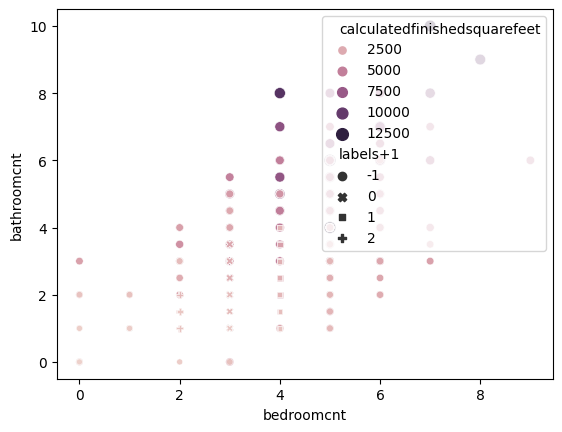

bedroomcnt <i  bathroomcnt <j  taxvaluedollarcnt <k


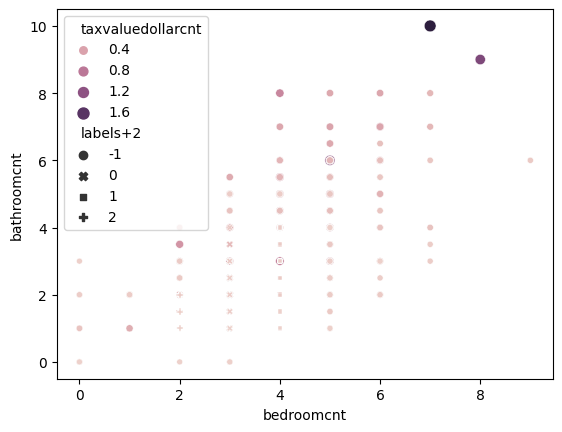

bedroomcnt <i  bathroomcnt <j  yearbuilt <k


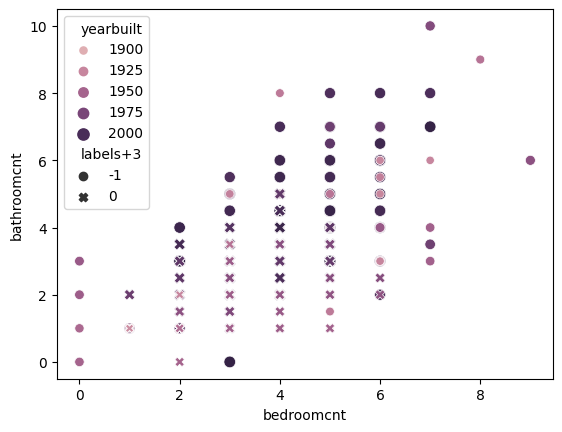

bedroomcnt <i  bathroomcnt <j  lotsizesquarefeet <k


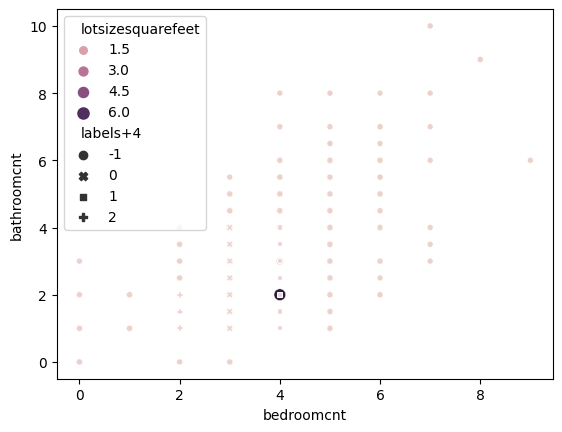

bedroomcnt <i  bathroomcnt <j  regionidzip <k


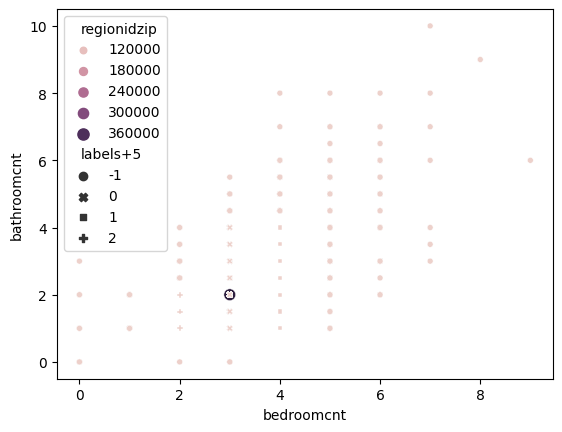

bedroomcnt <i  calculatedfinishedsquarefeet <j  taxvaluedollarcnt <k


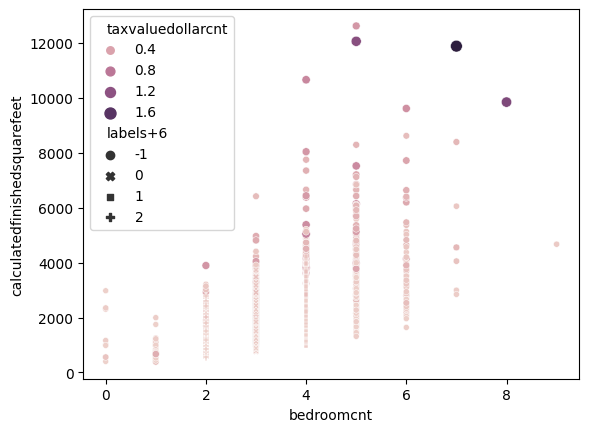

bedroomcnt <i  calculatedfinishedsquarefeet <j  yearbuilt <k


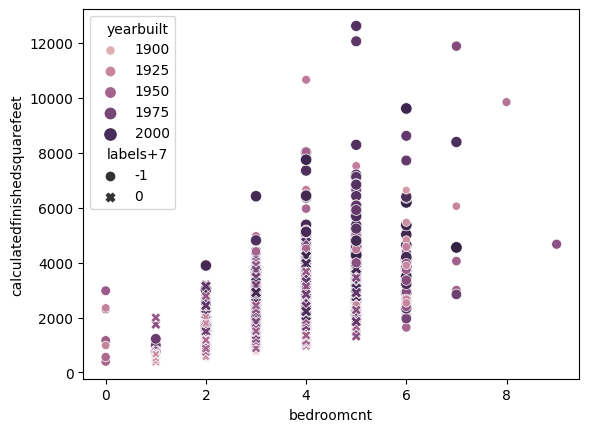

bedroomcnt <i  calculatedfinishedsquarefeet <j  lotsizesquarefeet <k


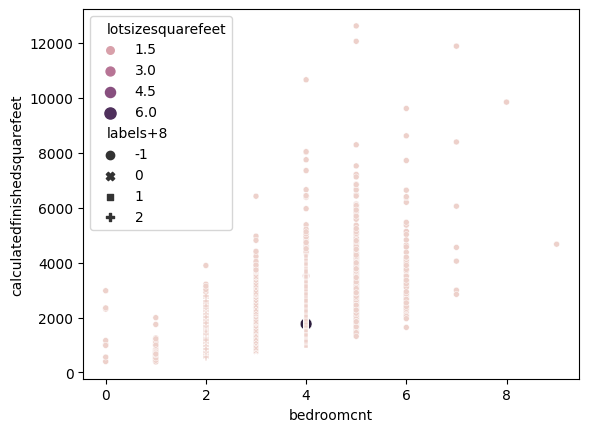

bedroomcnt <i  calculatedfinishedsquarefeet <j  regionidzip <k


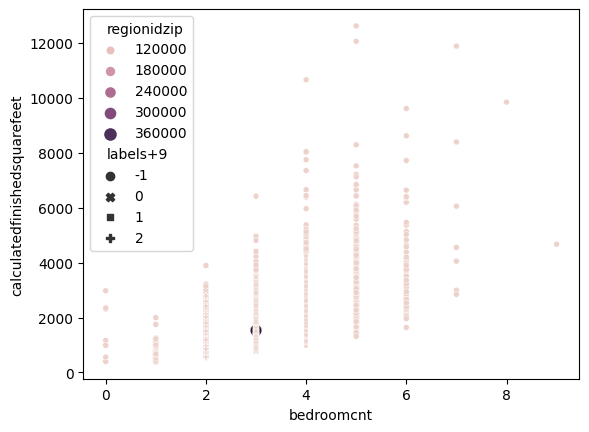

bedroomcnt <i  taxvaluedollarcnt <j  yearbuilt <k


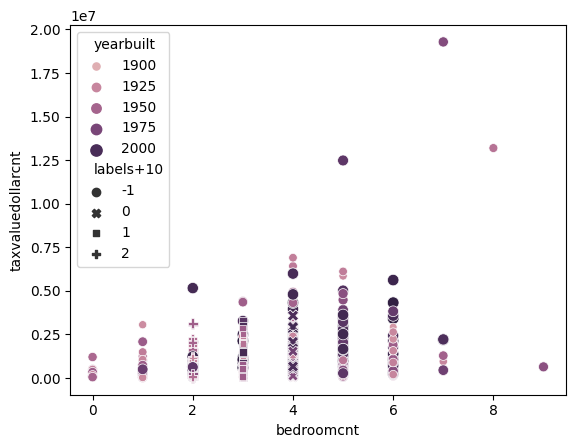

bedroomcnt <i  taxvaluedollarcnt <j  lotsizesquarefeet <k


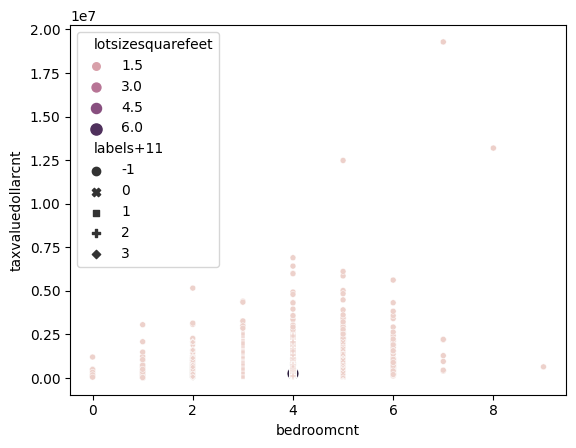

bedroomcnt <i  taxvaluedollarcnt <j  regionidzip <k


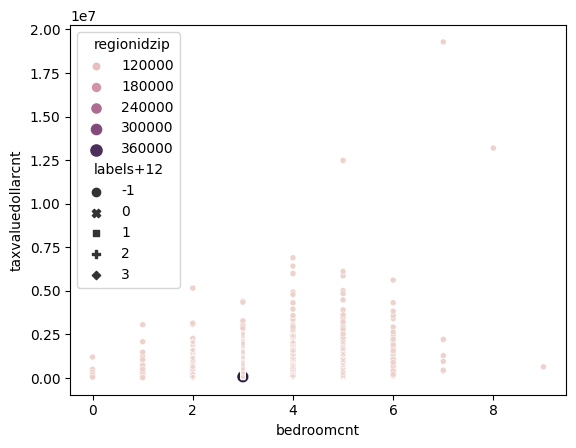

bedroomcnt <i  yearbuilt <j  lotsizesquarefeet <k


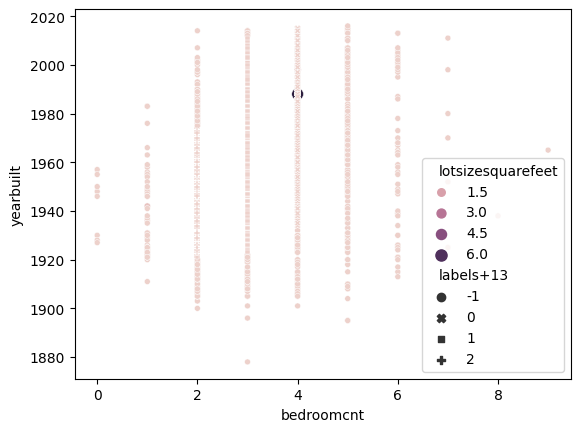

bedroomcnt <i  yearbuilt <j  regionidzip <k


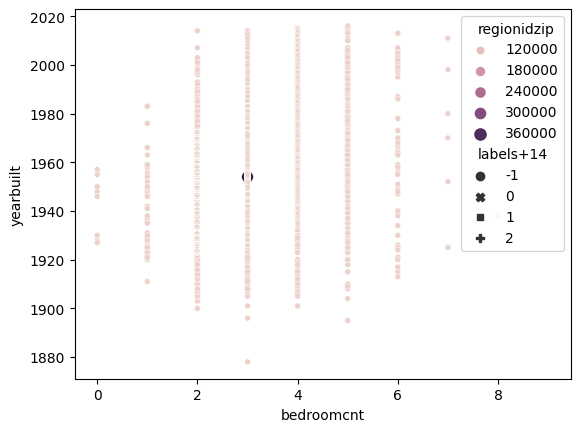

bedroomcnt <i  lotsizesquarefeet <j  regionidzip <k


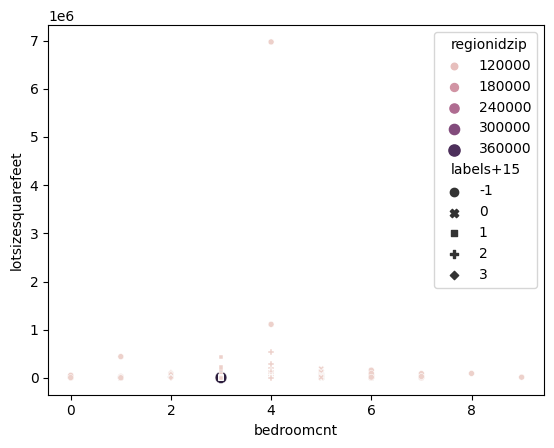

bathroomcnt <i  calculatedfinishedsquarefeet <j  taxvaluedollarcnt <k


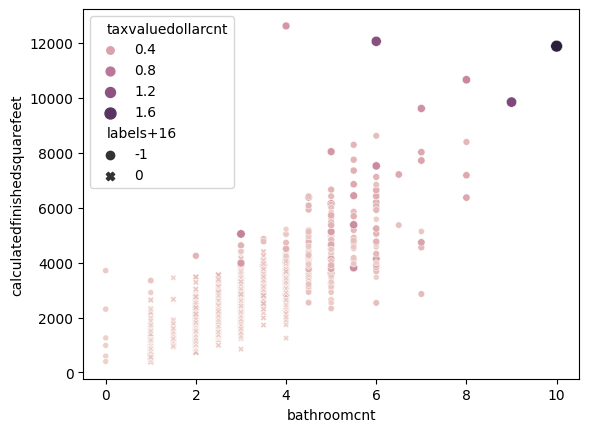

bathroomcnt <i  calculatedfinishedsquarefeet <j  yearbuilt <k


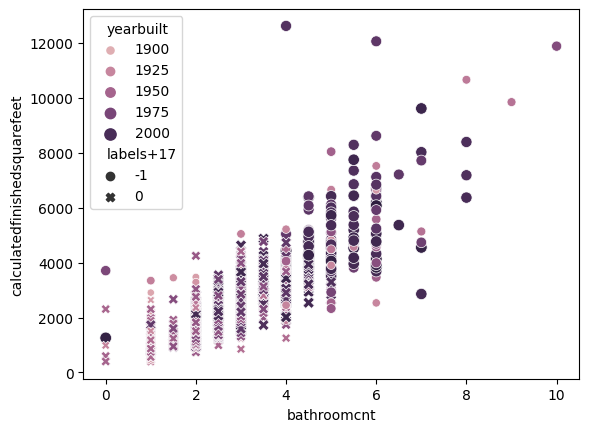

bathroomcnt <i  calculatedfinishedsquarefeet <j  lotsizesquarefeet <k


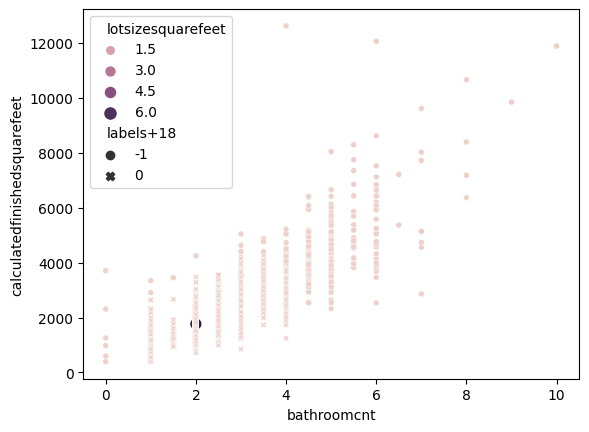

bathroomcnt <i  calculatedfinishedsquarefeet <j  regionidzip <k


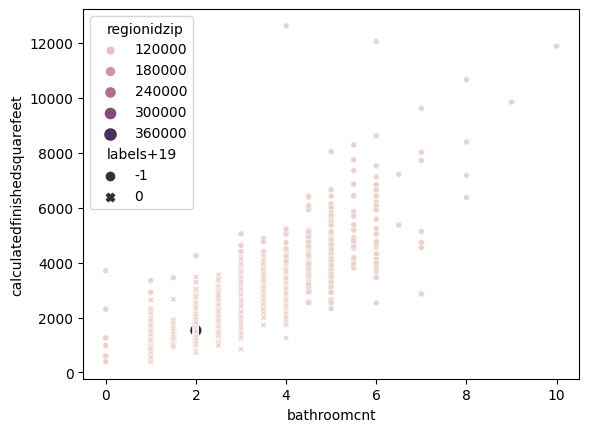

bathroomcnt <i  taxvaluedollarcnt <j  yearbuilt <k


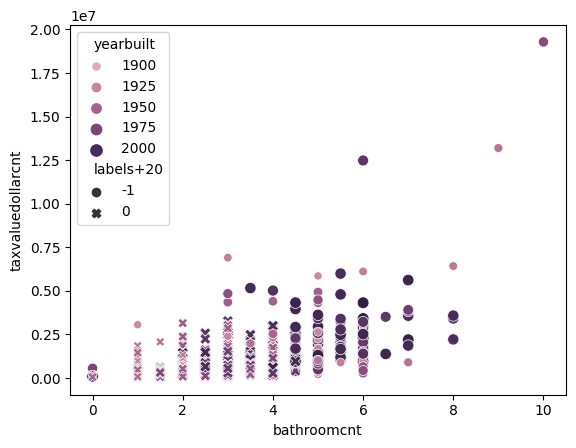

bathroomcnt <i  taxvaluedollarcnt <j  lotsizesquarefeet <k


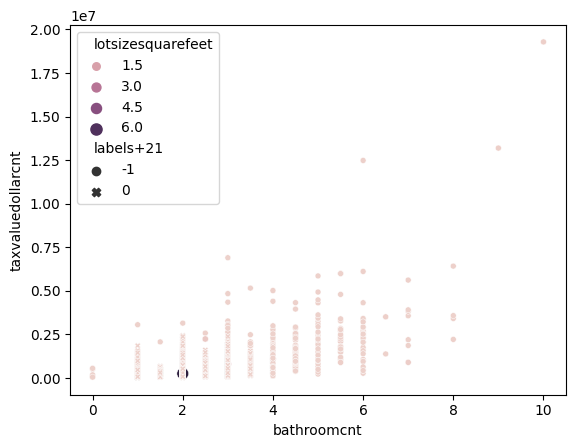

bathroomcnt <i  taxvaluedollarcnt <j  regionidzip <k


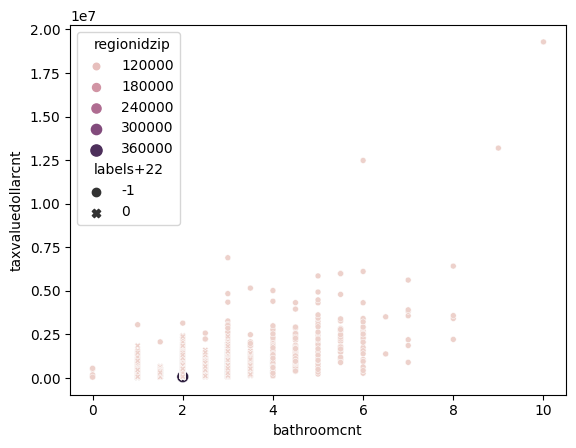

bathroomcnt <i  yearbuilt <j  lotsizesquarefeet <k


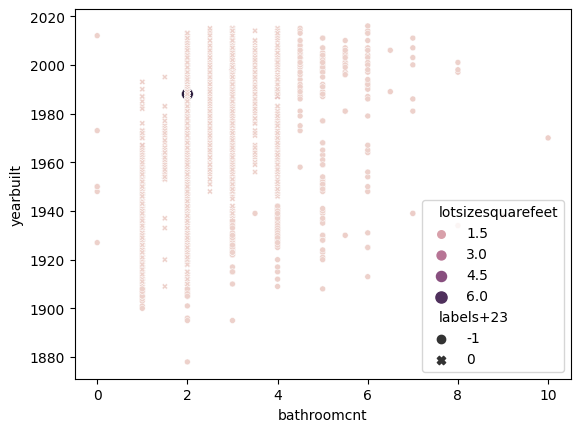

bathroomcnt <i  yearbuilt <j  regionidzip <k


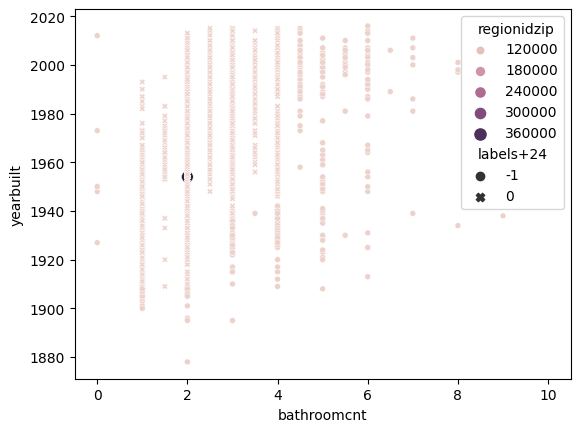

bathroomcnt <i  lotsizesquarefeet <j  regionidzip <k


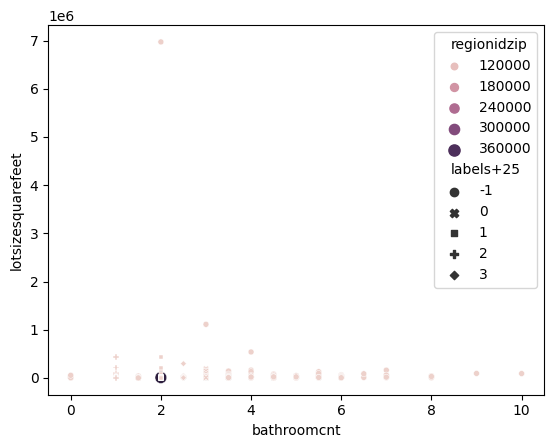

calculatedfinishedsquarefeet <i  taxvaluedollarcnt <j  yearbuilt <k


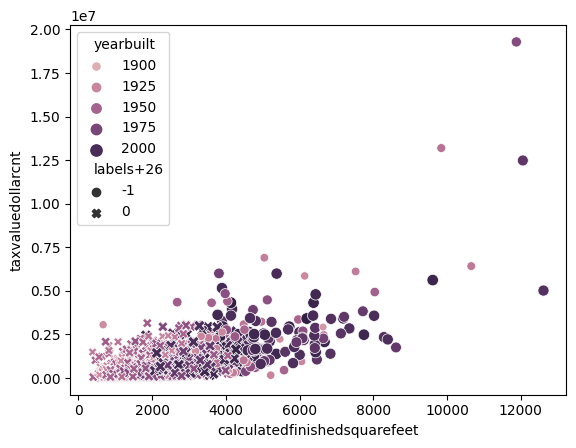

calculatedfinishedsquarefeet <i  taxvaluedollarcnt <j  lotsizesquarefeet <k


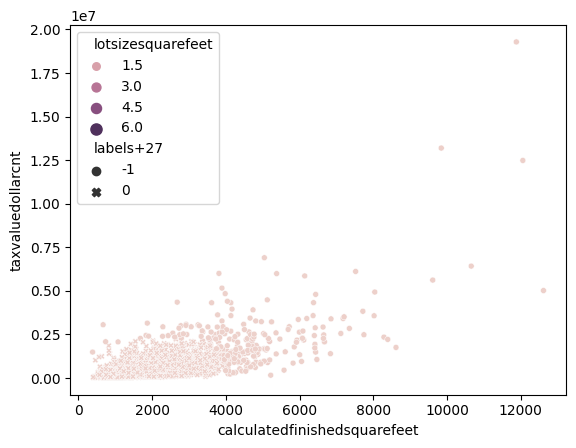

calculatedfinishedsquarefeet <i  taxvaluedollarcnt <j  regionidzip <k


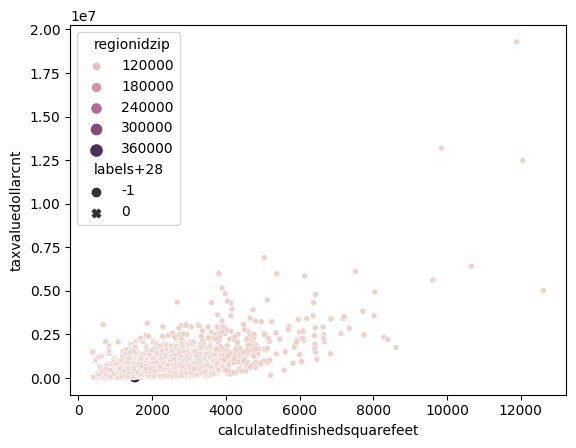

calculatedfinishedsquarefeet <i  yearbuilt <j  lotsizesquarefeet <k


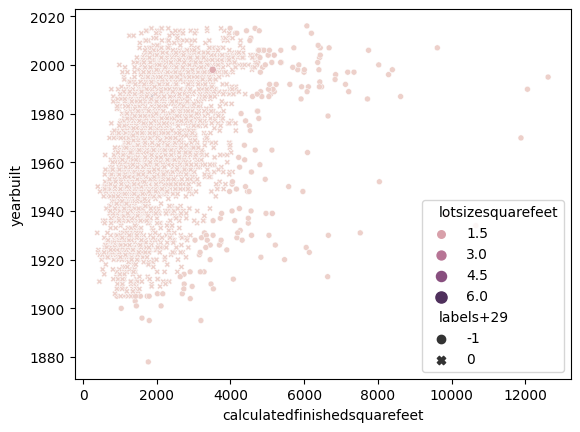

calculatedfinishedsquarefeet <i  yearbuilt <j  regionidzip <k


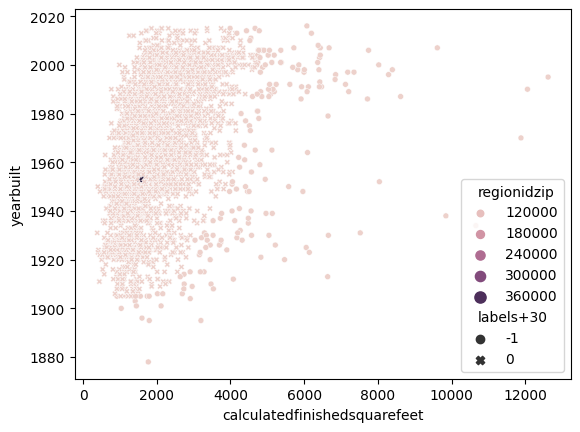

calculatedfinishedsquarefeet <i  lotsizesquarefeet <j  regionidzip <k


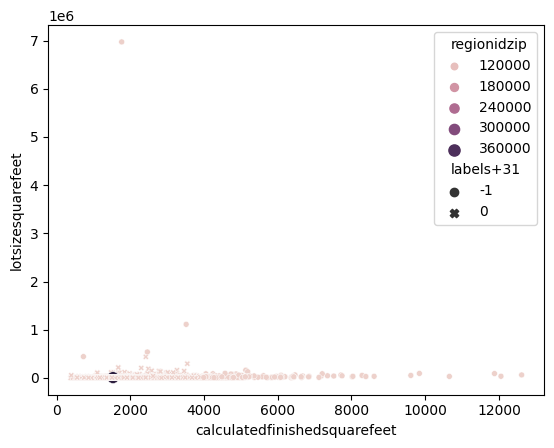

taxvaluedollarcnt <i  yearbuilt <j  lotsizesquarefeet <k


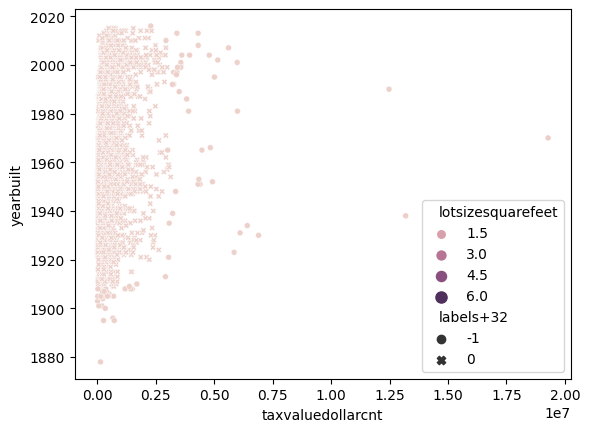

taxvaluedollarcnt <i  yearbuilt <j  regionidzip <k


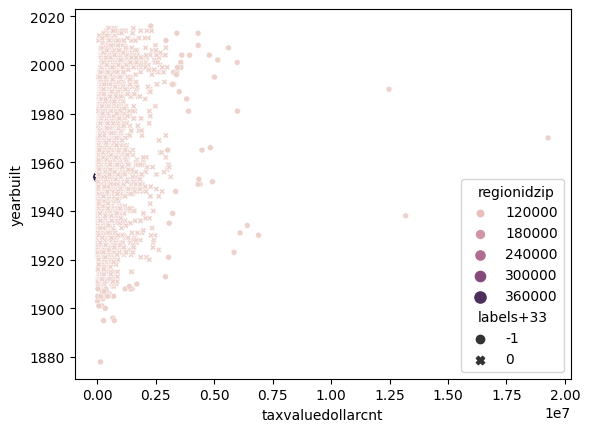

taxvaluedollarcnt <i  lotsizesquarefeet <j  regionidzip <k


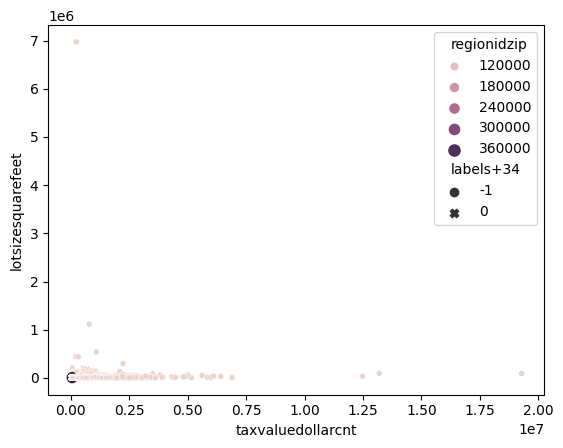

yearbuilt <i  lotsizesquarefeet <j  regionidzip <k


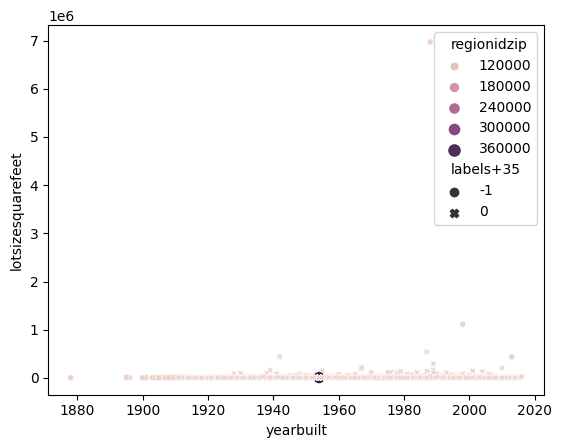

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,fips,lotsizesquarefeet,regionidzip,labels+1,labels+2,...,labels+27,labels+28,labels+29,labels+30,labels+31,labels+32,labels+33,labels+34,labels+35,outlier_cat
30243,5.0,3.0,2524.0,1049000.0,1972.0,6059.0,6250.0,96962.0,-1,-1,...,0,0,0,0,0,0,0,0,0,major_anom
20850,3.0,3.0,1398.0,725192.0,1922.0,6037.0,4960.0,96000.0,0,0,...,0,0,0,0,0,0,0,0,0,major_anom
45191,4.0,2.0,1618.0,611354.0,1974.0,6059.0,12600.0,97078.0,1,1,...,0,0,0,0,0,0,0,0,0,not_outlier
20284,3.0,2.0,1224.0,246468.0,1958.0,6059.0,8096.0,97065.0,0,0,...,0,0,0,0,0,0,0,0,0,not_outlier
38964,2.0,1.0,916.0,364079.0,1956.0,6037.0,3750.0,96292.0,2,2,...,0,0,0,0,0,0,0,0,0,not_outlier
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23346,4.0,3.0,2417.0,733000.0,1985.0,6037.0,7577.0,96342.0,1,1,...,0,0,0,0,0,0,0,0,0,not_outlier
10295,3.0,2.0,1479.0,78444.0,1955.0,6037.0,6528.0,96497.0,0,0,...,0,0,0,0,0,0,0,0,0,not_outlier
8569,4.0,3.0,2199.0,552957.0,1987.0,6037.0,6920.0,96395.0,1,1,...,0,0,0,0,0,0,0,0,0,not_outlier
39021,3.0,2.0,1506.0,528000.0,1955.0,6059.0,6780.0,97041.0,0,0,...,0,0,0,0,0,0,0,0,0,not_outlier


In [6]:
# start with fresh dataframe
df = df2.copy()
print(len(df))
df.dropna(inplace=True)
df = df.sample(n=5000, random_state=123)
print(len(df))
# making iterable list
products=['bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet','taxvaluedollarcnt','yearbuilt','lotsizesquarefeet',"regionidzip"]

x=0
for i,j,k in list(itertools.combinations(products, 3)):
    print(i,"<i ",j,"<j ",k,"<k")
    #Make the scaler
    scaler = MinMaxScaler()

    # Fit the scaler
    scaler.fit(df[[i,j,k]])

    # Use the scaler
    scaled_array = scaler.transform(df[[i,j,k]])

    scaled_df = pd.DataFrame(scaled_array, columns=["Scaled_" + column for column in [i,j,k]])
    #df = df.merge(scaled_df, on=df.index)
    #df = df.drop(columns=['key_0'])

    # Make the object
    dbsc = DBSCAN(eps = scaled_df.std().mean(), min_samples = int(len(df)*.68*.1))

    # Fit the object
    dbsc.fit(scaled_df)

    #assigning the object
    x += 1
    df[f'labels+{x}'] = dbsc.labels_

    #plot it 2d
    sns.scatterplot(data= df,x=i, y=j, hue=k, size=k, style=f'labels+{x}')
    plt.show()
    #plot it 3d
    #fig = px.scatter_3d(data_frame = df,x = i,y = j,z = k,color = f'labels+{x}',)
    #fig.update_traces(marker_size = 3)
    #fig.show()
df["outlier_cat"] = np.where(df.filter(like="labels").sum(axis=1) >= 0,"not_outlier",
                    np.where(df.filter(like="labels").sum(axis=1) < df.filter(like="labels").sum(axis=1).sort_values().unique().min()*1/3,"minor_anom",
                    np.where(df.filter(like="labels").sum(axis=1) < df.filter(like="labels").sum(axis=1).sort_values().unique().min()*2/3,"nom_anom",
                    "major_anom")))
df

In [11]:
df[df.outlier_cat=="major_anom"]

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,fips,lotsizesquarefeet,regionidzip,labels+1,labels+2,...,labels+27,labels+28,labels+29,labels+30,labels+31,labels+32,labels+33,labels+34,labels+35,outlier_cat
30243,5.0,3.0,2524.0,1049000.0,1972.0,6059.0,6250.0,96962.0,-1,-1,...,0,0,0,0,0,0,0,0,0,major_anom
20850,3.0,3.0,1398.0,725192.0,1922.0,6037.0,4960.0,96000.0,0,0,...,0,0,0,0,0,0,0,0,0,major_anom
28437,1.0,1.0,545.0,154210.0,1936.0,6037.0,2757.0,96119.0,-1,-1,...,0,0,0,0,0,0,0,0,0,major_anom
19674,3.0,3.5,4398.0,918910.0,1988.0,6059.0,6510.0,96982.0,-1,0,...,-1,-1,0,0,-1,0,0,0,0,major_anom
45229,5.0,2.0,2286.0,809739.0,1918.0,6037.0,6085.0,96027.0,-1,-1,...,0,0,0,0,0,0,0,0,0,major_anom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39228,5.0,2.0,1859.0,596452.0,1963.0,6059.0,6000.0,97052.0,-1,-1,...,0,0,0,0,0,0,0,0,0,major_anom
37234,5.0,1.0,1665.0,92660.0,1952.0,6037.0,6653.0,96171.0,-1,-1,...,0,0,0,0,0,0,0,0,0,major_anom
47612,5.0,3.0,3037.0,502458.0,1969.0,6037.0,17316.0,96379.0,-1,-1,...,0,0,0,0,0,0,0,0,0,major_anom
22753,5.0,3.0,1850.0,370842.0,1986.0,6037.0,7593.0,96368.0,-1,-1,...,0,0,0,0,0,0,0,0,0,major_anom
